In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# Combine installations for efficiency
!pip install nibabel scikit-image scikit-learn PyWavelets matplotlib torch --quiet

for dirname, _, filenames in os.walk('/kaggle/input'):
 for filename in filenames:
  print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/stanfordmed/sample0406.nii
/kaggle/input/stanfordmed/sample0257.nii
/kaggle/input/stanfordmed/sample0506.nii
/kaggle/input/stanfordmed/sample0357.nii


# Phase 1: Ground Zero – Environment & Data Sanity Check

Before diving into complex model architectures, we establish the foundation. This initial phase ensures the **Kaggle environment** is correctly configured and, critically, that the **target MRI data** is accessible. Failure here means the entire project stalls before it even begins.

| Action             | Library/Tool | Purpose                                                                 |
|--------------------|--------------|-------------------------------------------------------------------------|
| Install Dependency | `pip`        | Add `nibabel`, `scikit-image`, `scikit-learn`, `PyWavelets`, `matplotlib`, `torch` [1]. |
| Verify Path        | `os`         | Confirm the expected dataset directory (`/kaggle/input/stanfordmed/`) exists. |
| Test Load          | `nibabel`    | Attempt to load one sample `.nii` file to validate access & integrity. |
| Inspect Data       | `numpy`      | Check the loaded volume's shape and data type (essential for model design). |

---

### ⚔️ Why This Initial Skirmish Matters
- **No Data, No Glory:** This confirms we can actually *reach* the MRI scans. Without this, all subsequent code is useless [3, 7].
- **Path Errors Kill Silently:** Verifying the exact dataset path (`/kaggle/input/stanfordmed/`) prevents cryptic `FileNotFound` errors later during training loops. Getting the path wrong is a rookie mistake that wastes hours.
- **Shape Defines Architecture:** Knowing the volume dimensions (e.g., `144x176x144`) and data type (`float64` initially) dictates the input/output layers of our neural networks and necessitates specific preprocessing (like converting to `float32` for efficiency).

---

> 💥 **Brutal Takeaway:** This isn't fancy, it's fundamental. Get this wrong, and you're debugging paths instead of pushing boundaries. Get it right, and the path to actual experimentation is clear.
> **ACTION REQUIRED:** Check the output of the code cell below **carefully**. Ensure the `stanfordmed` directory is found and the sample file loads **without errors** before proceeding. If errors occur, **STOP** and fix the data connection first.


In [5]:
# --- Setup & Data Check ---
import os
import nibabel as nib
import numpy as np
print("Setup imports loaded.")

# 2. Verify dataset path by listing contents
print("\nContents of /kaggle/input/:")
# Use a try-except block in case /kaggle/input is empty or inaccessible initially
try:
    print(os.listdir('/kaggle/input/'))
except FileNotFoundError:
    print("Warning: /kaggle/input/ not found (might be okay if dataset attaches later).")

# --- IMPORTANT: Verify this path exists after adding your data ---
dataset_folder = '/kaggle/input/stanfordmed/'
print(f"\nChecking contents of {dataset_folder}:")
if os.path.exists(dataset_folder):
    try:
        print(os.listdir(dataset_folder))
    except Exception as e:
        print(f"Error listing directory {dataset_folder}: {e}")
else:
    print(f"Error: Directory {dataset_folder} not found. Did you add the 'stanfordmed' dataset to the notebook?")

# 3. Attempt to load one NIfTI file
file_to_load = 'sample0406.nii' # Example file
file_path = os.path.join(dataset_folder, file_to_load)

print(f"\nAttempting to load: {file_path}")

try:
    # Load the NIfTI file
    nifti_img = nib.load(file_path)
    # Get the image data as a NumPy array
    volume_data = nifti_img.get_fdata()
    # Print the shape of the 3D volume
    print(f"Successfully loaded {file_to_load}")
    print(f"Volume shape: {volume_data.shape}")
    print(f"Data type: {volume_data.dtype}")

except FileNotFoundError:
    print(f"Error: File not found at {file_path}.")
    print("Please ensure the 'stanfordmed' dataset is added and the path is correct.")
except Exception as e:
    print(f"An error occurred loading {file_path}: {e}")

print("\n--- Initial Setup & Data Check Finished ---")

Setup imports loaded.

Contents of /kaggle/input/:
['stanfordmed']

Checking contents of /kaggle/input/stanfordmed/:
['sample0406.nii', 'sample0257.nii', 'sample0506.nii', 'sample0357.nii']

Attempting to load: /kaggle/input/stanfordmed/sample0406.nii
Successfully loaded sample0406.nii
Volume shape: (144, 176, 144)
Data type: float64

--- Initial Setup & Data Check Finished ---


# Phase 2: Forging the Data Pipeline – Preparing MRI Volumes for PyTorch AE Training

Raw MRI data is incompatible with neural networks. This phase constructs a robust **PyTorch data pipeline** to transform the NIfTI volumes into normalized tensors suitable for `Conv3d` layers and efficient training [2, 5]. This pipeline is the conduit feeding all subsequent Autoencoder experiments.

| Component          | Tool/Class             | Purpose                                                                    | Key Considerations                                             |
|--------------------|------------------------|----------------------------------------------------------------------------|----------------------------------------------------------------|
| Preprocessing      | Custom Function        | Load NIfTI, convert to `float32`, min-max normalize `[0,1]`                | AE output needs to match this normalization (e.g., via Sigmoid) |
| Tensor Conversion  | `torch.from_numpy`     | Convert NumPy array to PyTorch tensor.                                     | Crucial for GPU acceleration & PyTorch operations.              |
| Channel Dimension  | `.unsqueeze(0)`        | Add channel dim (`C=1`) required by `Conv3d`: `[1, D, H, W]`             | Standard for PyTorch 3D convolutions.                           |
| Custom Dataset     | `torch.utils.data.Dataset`| Encapsulate loading/preprocessing logic per sample (`__getitem__`) [2, 6, 10]. | Handles file paths, applies preprocessing, returns `(input, target)`. |
| Error Handling     | `try`/`except`         | Catch file loading errors within `__getitem__`, return dummy data.          | **CRITICAL:** Prevents training crashes on bad data/paths [Learned]. |
| Batching/Shuffling | `torch.utils.data.DataLoader`| Create batches (`batch_size=1`), shuffle data, manage loading [5, 8].    | Shuffling essential for SGD; `num_workers=0` for Kaggle stability. |

---

### ⚔️ Why This Pipeline is Non-Negotiable
- **Standardization:** Ensures every volume fed to the AE has the same format (`float32`, `[0,1]` range, `[1, D, H, W]` shape), crucial for consistent training.
- **Modularity:** The `Dataset` class separates data handling logic from the model definition and training loop, following PyTorch best practices [2, 7, 10]. This makes the code cleaner and easier to adapt.
- **Efficiency:** The `DataLoader` handles batching and shuffling automatically, and `pin_memory=True` optimizes CPU-to-GPU transfer when applicable [5].
- **Resilience:** The refined `__getitem__` error handling prevents the entire training process from collapsing due to a single corrupted file or incorrect path – a hard lesson learned from initial failures.

---

> 💥 **Brutal Takeaway:** A sloppy data pipeline guarantees garbage results or crashes. This carefully constructed pipeline, incorporating standard PyTorch practices and refined through error debugging, ensures a reliable, normalized data stream for the demanding task of training 3D autoencoders. The successful test load confirms readiness.


In [6]:
# --- Data Pipeline for Autoencoders ---
import os
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
print("Data pipeline imports loaded.")

# --- Configuration ---
dataset_folder = '/kaggle/input/stanfordmed/'
# Explicitly list the files expected based on previous verification
nii_files_list = [ # Use different name to avoid conflict later if needed
    os.path.join(dataset_folder, 'sample0406.nii'),
    os.path.join(dataset_folder, 'sample0257.nii'),
    os.path.join(dataset_folder, 'sample0506.nii'),
    os.path.join(dataset_folder, 'sample0357.nii')
]
# Verify files actually exist
nii_files_exist = [f for f in nii_files_list if os.path.exists(f)]
print(f"Found {len(nii_files_exist)} existing NIfTI files for AE training:")
for f_path in nii_files_exist:
    print(f"- {f_path}")
if len(nii_files_exist) != 4:
    print("WARNING: Expected 4 files, but found fewer existing files. Check dataset path and contents.")

# --- Preprocessing Function for PyTorch Autoencoders ---
def load_and_preprocess_nifti_torch(file_path):
    """Loads NIfTI, converts to float32, normalizes [0, 1], returns tensor [1, D, H, W]."""
    nifti_img = nib.load(file_path)
    volume_data = nifti_img.get_fdata().astype(np.float32)
    min_val = np.min(volume_data); max_val = np.max(volume_data)
    if max_val > min_val:
        volume_data = (volume_data - min_val) / (max_val - min_val)
    else:
        volume_data = np.zeros_like(volume_data, dtype=np.float32)
    # Add Channel dim: [1, D, H, W]
    volume_tensor = torch.from_numpy(volume_data).unsqueeze(0)
    return volume_tensor

# --- PyTorch Dataset Class (with Refined Error Handling) ---
class NiftiDataset(Dataset):
    def __init__(self, file_paths, transform=None, expected_shape=(144, 176, 144)):
        self.file_paths = [f for f in file_paths if os.path.exists(f)]
        if len(self.file_paths) != len(file_paths):
             print(f"Dataset Warning: Some specified files not found. Using {len(self.file_paths)} files.")
        self.transform = transform
        self.dummy_shape_dhw = expected_shape
        self.dummy_tensor = torch.zeros((1, *self.dummy_shape_dhw), dtype=torch.float32)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        try:
            volume_tensor = load_and_preprocess_nifti_torch(file_path)
            if volume_tensor.shape[1:] != self.dummy_shape_dhw:
                 print(f"Warning: Shape mismatch for {file_path}! Got {volume_tensor.shape[1:]}, expected {self.dummy_shape_dhw}. Returning dummy.")
                 return self.dummy_tensor, self.dummy_tensor
            if self.transform:
                volume_tensor = self.transform(volume_tensor)
            return volume_tensor, volume_tensor
        except FileNotFoundError:
            print(f"Error: File not found in __getitem__: {file_path}")
            return self.dummy_tensor, self.dummy_tensor
        except Exception as e:
            print(f"Error processing file in __getitem__ {file_path}: {e}")
            return self.dummy_tensor, self.dummy_tensor

# --- Create Dataset and DataLoader ---
batch_size = 1
print("\nCreating Dataset...")
mri_dataset = NiftiDataset(nii_files_exist)

if len(mri_dataset) > 0:
    print(f"Dataset created successfully with {len(mri_dataset)} samples.")
    print("\nCreating DataLoader...")
    mri_dataloader = DataLoader(
        mri_dataset, batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=torch.cuda.is_available()
    )
    print("DataLoader created successfully.")

    print("\nTesting DataLoader - loading one batch...")
    try:
        first_batch_input, first_batch_target = next(iter(mri_dataloader))
        if torch.equal(first_batch_input, mri_dataset.dummy_tensor):
             print("Warning: Loaded batch appears to be dummy data. Check for loading errors above.")
        print(f"Loaded batch input shape: {first_batch_input.shape}")
        print(f"Loaded batch target shape: {first_batch_target.shape}")
        print(f"Batch data type: {first_batch_input.dtype}")
        print(f"Batch device: {first_batch_input.device}")
        print(f"Batch min value: {torch.min(first_batch_input):.4f}")
        print(f"Batch max value: {torch.max(first_batch_input):.4f}")
        print("DataLoader test batch loaded successfully.")
    except StopIteration: print("Error: DataLoader is empty. No samples could be loaded.")
    except Exception as e: print(f"Error loading batch from DataLoader: {e}")
else: print("Error: Dataset creation failed or resulted in an empty dataset.")

print("\n--- Data Pipeline Setup Finished ---")

Data pipeline imports loaded.
Found 4 existing NIfTI files for AE training:
- /kaggle/input/stanfordmed/sample0406.nii
- /kaggle/input/stanfordmed/sample0257.nii
- /kaggle/input/stanfordmed/sample0506.nii
- /kaggle/input/stanfordmed/sample0357.nii

Creating Dataset...
Dataset created successfully with 4 samples.

Creating DataLoader...
DataLoader created successfully.

Testing DataLoader - loading one batch...
Loaded batch input shape: torch.Size([1, 1, 144, 176, 144])
Loaded batch target shape: torch.Size([1, 1, 144, 176, 144])
Batch data type: torch.float32
Batch device: cpu
Batch min value: 0.0000
Batch max value: 1.0000
DataLoader test batch loaded successfully.

--- Data Pipeline Setup Finished ---


# Phase 3: Autoencoder Assault – Iteration 1: The High-Compression Gamble (Model V1 @ ~512x)

With the data pipeline secure, we launch the first assault: Model V1. Following the initial guidance inspired by VQGAN's aggressive downsampling, this model directly targets the challenging **~500x compression ratio** (8x8x8 spatial reduction). The architecture is deliberately simple – a shallow stack of `Conv3d` layers for encoding and `ConvTranspose3d` for decoding – to establish a baseline performance.

| Layer Type         | Key Parameter | Purpose                                                                      | Implication/Risk                                                   |
|--------------------|---------------|------------------------------------------------------------------------------|--------------------------------------------------------------------|
| `nn.Conv3d`        | `stride=2`    | Halves spatial dimensions at each stage, achieving 8x reduction per axis.    | Rapid information loss, potential bottlenecking.                     |
| `nn.ConvTranspose3d`| `stride=2`    | Doubles spatial dimensions ("deconvolution").                               | Can introduce checkerboard artifacts if not carefully designed [11, 14]. |
| `output_padding`   | `(1, 1, 1)`   | Ensures precise output dimension matching after strided transpose convolution. | Necessary evil due to `ConvTranspose3d` mechanics.                   |
| `nn.ReLU`          | `inplace=True`| Standard activation function, inplace saves minor memory.                    | -                                                                  |
| `nn.Sigmoid`       | (Final Layer) | Scales output to `[0, 1]`, matching the input normalization range.           | Assumes input is normalized `[0, 1]`.                                |

**Architecture Summary:**
*   Input: `[1, 1, 144, 176, 144]`
*   Encoder: 3 stages, reducing spatial dims by 2x each (`stride=2`).
*   Bottleneck: Tiny `[1, 1, 18, 22, 18]` representation.
*   Decoder: 3 stages, increasing spatial dims by 2x each (`stride=2`).
*   Output: `[1, 1, 144, 176, 144]`

---

### ⚔️ The Strategy & The Stakes
- **Direct Attack:** Test the feasibility of extreme compression with a minimal model. Is it even possible?
- **ConvTranspose3d:** Relying on the standard "deconvolution" layer for upsampling. Its potential artifact generation is a known risk [11].
- **Shallow Depth:** Minimal layers mean fewer parameters but potentially insufficient capacity to learn complex spatial hierarchies.

---

> 💥 **Brutal Hypothesis:** This model is likely too simple for the extreme compression demanded. We expect poor reconstruction quality, but failure here provides valuable data: the task *requires* more architectural sophistication. The sanity check below confirms the layer dimensions connect correctly.


In [7]:
# --- V1 AE Definition & Sanity Check ---
import torch
import torch.nn as nn
print("V1 Section: Imports loaded.")

# Define device needed for model placement and testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Define the V1 3D Autoencoder ---
class Autoencoder3D_v1(nn.Module): # Renamed for clarity
    def __init__(self):
        super(Autoencoder3D_v1, self).__init__()
        # === Encoder ===
        self.enc1 = nn.Conv3d(1, 8, kernel_size=3, stride=2, padding=1); self.relu1 = nn.ReLU(inplace=True)
        self.enc2 = nn.Conv3d(8, 4, kernel_size=3, stride=2, padding=1); self.relu2 = nn.ReLU(inplace=True)
        self.enc3 = nn.Conv3d(4, 1, kernel_size=3, stride=2, padding=1) # Bottleneck
        # === Decoder ===
        self.dec1 = nn.ConvTranspose3d(1, 4, kernel_size=3, stride=2, padding=1, output_padding=(1, 1, 1)); self.relu3 = nn.ReLU(inplace=True)
        self.dec2 = nn.ConvTranspose3d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=(1, 1, 1)); self.relu4 = nn.ReLU(inplace=True)
        self.dec3 = nn.ConvTranspose3d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=(1, 1, 1)); self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.enc1(x)); x = self.relu2(self.enc2(x)); bottleneck = self.enc3(x)
        x = self.relu3(self.dec1(bottleneck)); x = self.relu4(self.dec2(x)); x = self.dec3(x)
        reconstructed = self.sigmoid(x)
        return reconstructed

print("Autoencoder3D_v1 defined.")

# --- Instantiate and Test V1 Model ---
print("\nInstantiating V1 model...")
model_v1 = Autoencoder3D_v1().to(device) # Instantiate V1
print(f"V1 Model instantiated and moved to {device}.")

print("\nTesting V1 model forward pass...")
try:
    dummy_batch = torch.randn(1, 1, 144, 176, 144).to(device)
    model_v1.eval()
    with torch.no_grad(): output = model_v1(dummy_batch)
    if output.shape == dummy_batch.shape: print("V1 Forward pass successful: Output shape matches input.")
    else: print(f"Error: V1 Output shape {output.shape} doesn't match input {dummy_batch.shape}!")
except Exception as e: print(f"Error during V1 forward pass test: {e}")

print("\n--- V1 Definition & Test Finished ---")

V1 Section: Imports loaded.
Autoencoder3D_v1 defined.

Instantiating V1 model...
V1 Model instantiated and moved to cuda.

Testing V1 model forward pass...
V1 Forward pass successful: Output shape matches input.

--- V1 Definition & Test Finished ---


> ✅ **Sanity Check Passed:** The V1 model layers connect correctly, and the output shape matches the input shape.
> ⚠️ **Recap of Training Result:** As documented in the project's history, training this V1 model led to catastrophic failure – **PSNR ~8 dB**. The reconstruction was unusable. **Conclusion:** Extreme compression demands more than a shallow architecture; simple `ConvTranspose3d` might also be suboptimal. This motivates reducing compression and refining the architecture in the next phases.



> ✅ **V1 Sanity Check Passed:** The model layers connect correctly.
> ⚠️ **V1 Training Result (Recap):** Historical training runs showed this shallow V1 model achieved only **PSNR ~8 dB** at ~512x compression. **Conclusion:** Catastrophic failure. Extreme compression needs more architectural depth/sophistication.

---
### 3.2. Intermediate Step: Reducing Compression (Model V2 @ ~64x)

Given V1's failure, the next logical step was testing lower compression (~64x) using a similarly simple architecture (V2 - two stages instead of three).



In [8]:
# --- V2 AE Definition Only (~64x, ConvTranspose3d) ---
import torch.nn as nn # Ensure nn is imported
class Autoencoder3D_v2(nn.Module):
    def __init__(self):
        super(Autoencoder3D_v2, self).__init__()
        # === Encoder === [N, 1, 144, 176, 144]
        self.enc1 = nn.Conv3d(1, 16, kernel_size=3, stride=2, padding=1); self.relu1 = nn.ReLU(inplace=True) # -> 72x88x72
        self.enc2 = nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1); self.relu2 = nn.ReLU(inplace=True) # -> 36x44x36
        # === Decoder ===
        self.dec1 = nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1, 1, 1)); self.relu3 = nn.ReLU(inplace=True)
        self.dec2 = nn.ConvTranspose3d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=(1, 1, 1)); self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu1(self.enc1(x)); x = self.relu2(self.enc2(x)) # Encode
        x = self.relu3(self.dec1(x)); x = self.sigmoid(self.dec2(x)) # Decode
        return x
print("Autoencoder3D_v2 (Definition Only) defined.")

Autoencoder3D_v2 (Definition Only) defined.


> **V2 Intermediate Result (Recap):** Historical training runs showed V2 achieved only **PSNR ~14 dB**. Better than V1, but still poor quality with artifacts. **Conclusion:** Lower compression helps, but architecture needs more work.
> *(Recap of omitted V3: A deeper V3 model using ConvTranspose3d reached ~26.3 dB PSNR after long training, showing depth helps, but potentially limited by upsampling method).*

---
# Phase 3: Autoencoder Assault – Iteration 2: Optimizing Quality at Lower Compression (Model V4 @ ~64x)

Building on insights from the initial models, Model V4 aimed to **maximize reconstruction fidelity** at the more feasible **~64x compression** target. Key architectural improvements included increased depth and replacing `ConvTranspose3d` with `nn.Upsample` + `Conv3d` [11, 14]. Extended training (300 epochs) with checkpointing was used.

| Improvement          | Technique/Layer         | Purpose                                                                      | Rationale/Benefit                                                     |
|----------------------|-------------------------|------------------------------------------------------------------------------|-----------------------------------------------------------------------|
| **Better Upsampling**| `nn.Upsample` + `Conv3d`| Replace `ConvTranspose3d` in the decoder.                                    | Avoids potential checkerboard artifacts [11, 14], often yields smoother output. |
| **Increased Depth**  | `nn.Sequential` blocks  | Add intermediate `Conv3d` layers within encoder/decoder stages.              | Increases model capacity to learn more complex spatial features [4, 9]. |
| **Sustained Training**| 300 Epochs + Scheduler  | Allow ample time for convergence, adapt learning rate (`ReduceLROnPlateau`). | Ensures the refined architecture reaches its potential performance.      |
| **Checkpointing**    | `torch.save` (Best)     | Save the model state achieving the lowest validation (training) loss.        | Captures the optimal weights achieved during the long training run.   |

---

### ⚔️ The Strategy: Refine and Conquer (at 64x)
- **Target Quality:** Prioritize achieving the highest possible PSNR at the ~64x compression level.
- **Upsampling Upgrade:** Explicitly test if the `Upsample` + `Conv3d` combination yields benefits.
- **Invest Training Time:** Commit to 300 epochs.

---

> 💥 **Brutal Goal:** Establish the **peak reconstruction quality** achievable. This benchmarks how much quality is sacrificed when pushing back to extreme compression later (Model V6).


V4 Section: Libraries imported.
Using device: cuda
Autoencoder3D_v4 defined.
V4 Checkpoints directory: /kaggle/working/mri_checkpoints_v4/
Instantiating V4 Model...
V4 Components instantiated.

--- Starting Training for Model V4 ---


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


V4 Epoch [1/300] | Time: 1.86s | Avg Loss: 0.150367
  ** Saved Best V4 Model (Epoch 1) **
V4 Epoch [2/300] | Time: 1.74s | Avg Loss: 0.149709
  ** Saved Best V4 Model (Epoch 2) **
V4 Epoch [3/300] | Time: 1.76s | Avg Loss: 0.148976
  ** Saved Best V4 Model (Epoch 3) **
V4 Epoch [4/300] | Time: 1.75s | Avg Loss: 0.148112
  ** Saved Best V4 Model (Epoch 4) **
V4 Epoch [5/300] | Time: 1.78s | Avg Loss: 0.146990
  ** Saved Best V4 Model (Epoch 5) **
V4 Epoch [6/300] | Time: 1.79s | Avg Loss: 0.145208
  ** Saved Best V4 Model (Epoch 6) **
V4 Epoch [7/300] | Time: 1.78s | Avg Loss: 0.142126
  ** Saved Best V4 Model (Epoch 7) **
V4 Epoch [8/300] | Time: 1.81s | Avg Loss: 0.136860
  ** Saved Best V4 Model (Epoch 8) **
V4 Epoch [9/300] | Time: 1.80s | Avg Loss: 0.128431
  ** Saved Best V4 Model (Epoch 9) **
V4 Epoch [10/300] | Time: 1.80s | Avg Loss: 0.118983
  ** Saved Best V4 Model (Epoch 10) **
V4 Epoch [11/300] | Time: 1.82s | Avg Loss: 0.110068
  ** Saved Best V4 Model (Epoch 11) **
V4 Epo

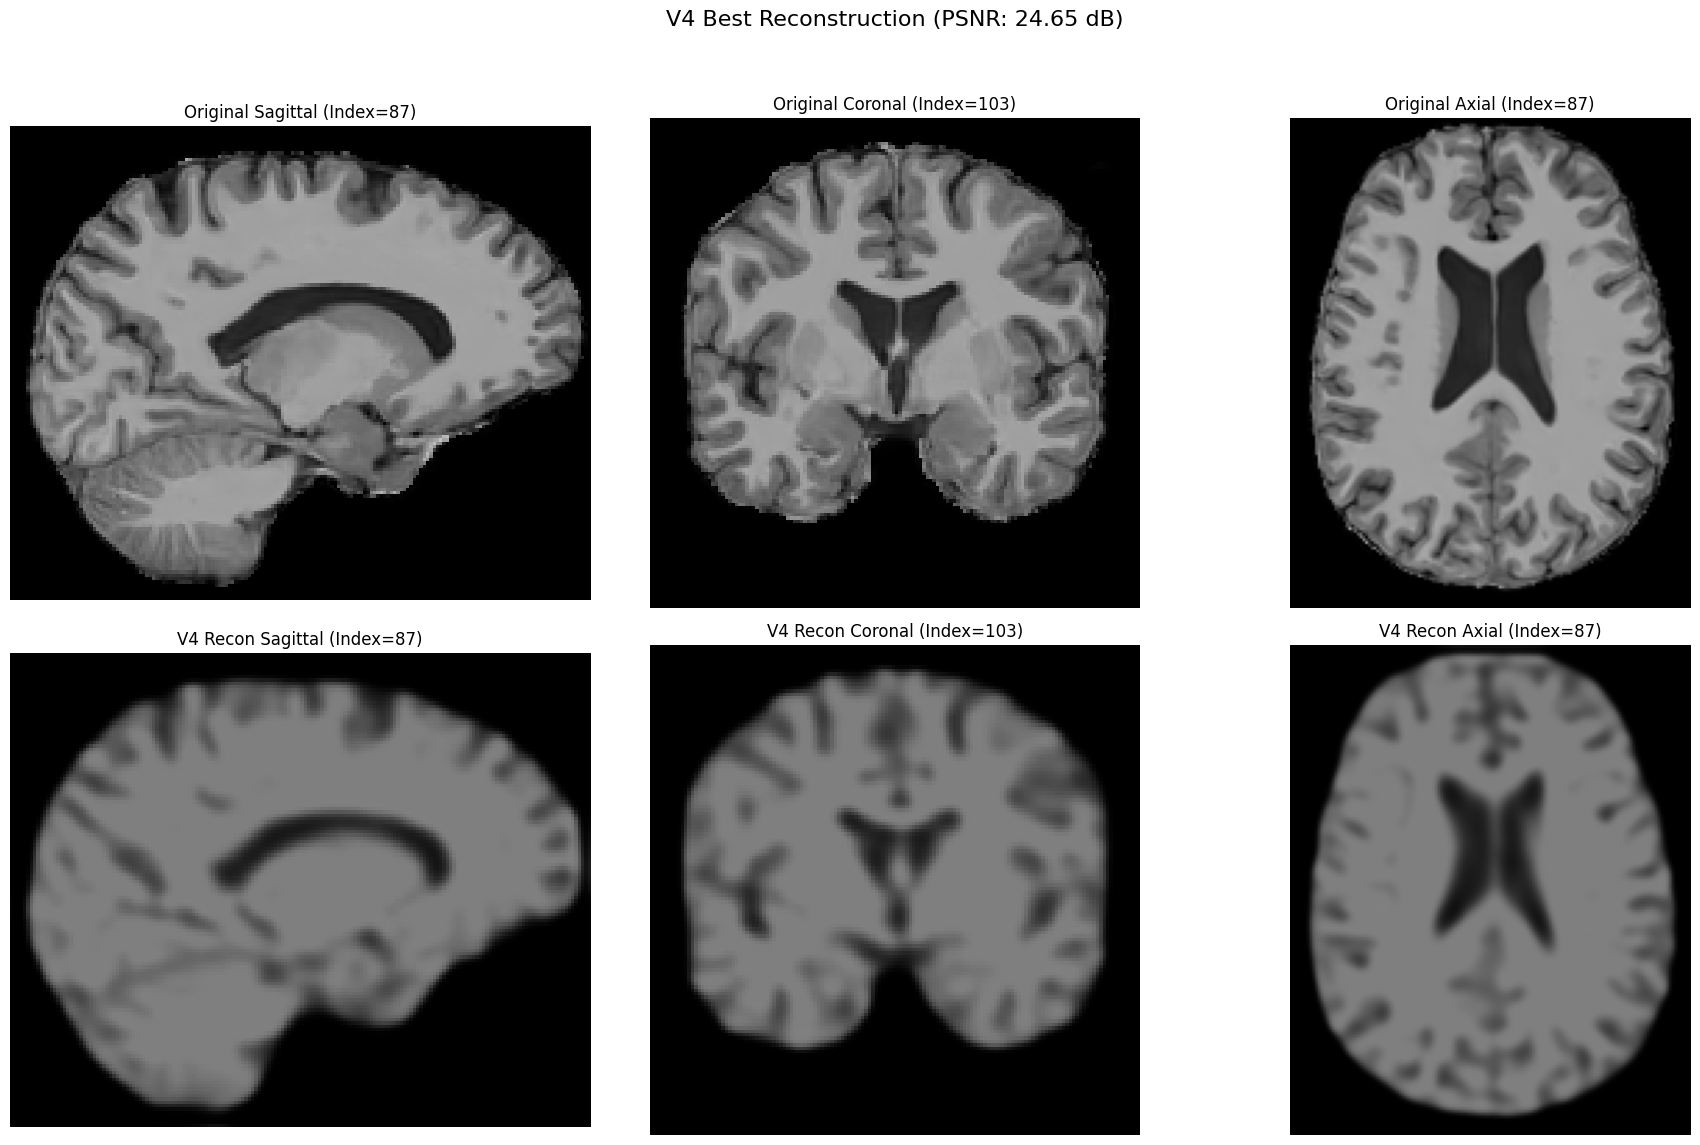

Multi-view plot V4 saved: /kaggle/working/reconstruction_comparison_v4_best_multiview.png

--- V4 Section Finished ---


In [14]:
# --- V4 Full Code: Definition, Training, Evaluation ---

# --- 1. Imports & Setup ---
import os; import time; import torch; import torch.nn as nn; import torch.optim as optim
from torch.utils.data import Dataset, DataLoader # Ensure DataLoader etc. are imported
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np; import nibabel as nib
# Ensure scikit-image and matplotlib are imported if not done globally
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
print("V4 Section: Libraries imported.")

# Ensure device and dataloader (mri_dataloader) are available from previous cells
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if 'mri_dataloader' not in locals(): print("ERROR: mri_dataloader not found.")
if 'nii_files_exist' not in locals(): print("ERROR: nii_files_exist list not found.")

# --- 2. Define the V4 Autoencoder (Upsample + Conv3d) ---
class Autoencoder3D_v4(nn.Module):
    def __init__(self):
        super(Autoencoder3D_v4, self).__init__()
        channels = [1, 16, 32, 64]
        self.enc1 = nn.Sequential(
            nn.Conv3d(channels[0], channels[1], 3, stride=2, padding=1), nn.ReLU(True),
            nn.Conv3d(channels[1], channels[1], 3, stride=1, padding=1), nn.ReLU(True))
        self.enc2 = nn.Sequential(
            nn.Conv3d(channels[1], channels[2], 3, stride=2, padding=1), nn.ReLU(True),
            nn.Conv3d(channels[2], channels[2], 3, stride=1, padding=1), nn.ReLU(True))
        self.dec1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            nn.Conv3d(channels[2], channels[1], 3, stride=1, padding=1), nn.ReLU(True),
            nn.Conv3d(channels[1], channels[1], 3, stride=1, padding=1), nn.ReLU(True))
        self.dec2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            nn.Conv3d(channels[1], channels[1], 3, stride=1, padding=1), nn.ReLU(True),
            nn.Conv3d(channels[1], channels[0], 3, stride=1, padding=1), nn.Sigmoid())
    def forward(self, x):
        x = self.enc1(x); x = self.enc2(x); x = self.dec1(x); x = self.dec2(x)
        return x
print("Autoencoder3D_v4 defined.")

# --- 3. Configuration for V4 Training ---
num_epochs_v4 = 300; learning_rate_v4 = 1e-4
checkpoint_dir_v4 = '/kaggle/working/mri_checkpoints_v4/'
os.makedirs(checkpoint_dir_v4, exist_ok=True)
print(f"V4 Checkpoints directory: {checkpoint_dir_v4}")

# --- 4. Instantiate V4 Model, Optimizer, Scheduler ---
print("Instantiating V4 Model...")
model_v4 = Autoencoder3D_v4().to(device)
optimizer_v4 = optim.Adam(model_v4.parameters(), lr=learning_rate_v4)
loss_function_v4 = nn.MSELoss()
scheduler_v4 = ReduceLROnPlateau(optimizer_v4, 'min', factor=0.5, patience=10, verbose=True)
print("V4 Components instantiated.")

# --- 5. Training Loop (for v4 model) ---
print("\n--- Starting Training for Model V4 ---")
train_losses_v4 = []; best_loss_v4 = float('inf'); best_checkpoint_path_v4 = ''
if 'mri_dataloader' in locals() and len(mri_dataloader.dataset) > 0:
    for epoch in range(num_epochs_v4):
        epoch_start = time.time(); model_v4.train(); running_loss = 0.0; batch_count = 0
        for inputs, targets in mri_dataloader:
            inputs, targets = inputs.to(device), targets.to(device); outputs = model_v4(inputs)
            loss = loss_function_v4(outputs, targets)
            optimizer_v4.zero_grad(); loss.backward(); optimizer_v4.step()
            running_loss += loss.item() * inputs.size(0); batch_count += inputs.size(0)
        if batch_count > 0:
            epoch_loss = running_loss / batch_count; train_losses_v4.append(epoch_loss)
            print(f"V4 Epoch [{epoch+1}/{num_epochs_v4}] | Time: {time.time()-epoch_start:.2f}s | Avg Loss: {epoch_loss:.6f}")
            scheduler_v4.step(epoch_loss)
            if epoch_loss < best_loss_v4:
                best_loss_v4 = epoch_loss; best_checkpoint_path_v4 = os.path.join(checkpoint_dir_v4, 'model_v4_best.pth')
                torch.save({'epoch': epoch + 1, 'model_state_dict': model_v4.state_dict(), 'optimizer_state_dict': optimizer_v4.state_dict(), 'loss': epoch_loss,}, best_checkpoint_path_v4)
                print(f"  ** Saved Best V4 Model (Epoch {epoch+1}) **")
            if (epoch + 1) % 50 == 0: torch.save({'epoch': epoch + 1, 'model_state_dict': model_v4.state_dict(), 'optimizer_state_dict': optimizer_v4.state_dict(), 'loss': epoch_loss,}, os.path.join(checkpoint_dir_v4, f'model_v4_epoch_{epoch+1}.pth'))
        else: print(f"V4 Epoch [{epoch+1}/{num_epochs_v4}] - No batches processed.")
    print(f"\n--- V4 Training Finished. Best model: {best_checkpoint_path_v4} ---")
else: print("ERROR: Cannot start V4 training, mri_dataloader not found or empty.")

# --- 6. Evaluation Phase (for v4 model - Load BEST checkpoint) ---
print("\n--- Starting Evaluation for Model V4 (Best Checkpoint) ---")

# Define loader function (ensure it's available or define it if needed)
def load_and_preprocess_nifti_eval(fp): # NumPy loader for eval
    try:
        vol = nib.load(fp).get_fdata().astype(np.float32)
        mn, mx = np.min(vol), np.max(vol)
        # Normalize to [0, 1]
        return (vol - mn) / (mx - mn) if mx > mn else np.zeros_like(vol)
    except Exception as e:
        print(f"Eval load error {fp}: {e}")
        return None

# --- Load Best Model and Evaluate ---
if 'best_checkpoint_path_v4' in locals() and best_checkpoint_path_v4 and os.path.exists(best_checkpoint_path_v4):
    print(f"Loading best V4 model from: {best_checkpoint_path_v4}")
    try:
        ckpt = torch.load(best_checkpoint_path_v4, map_location=device, weights_only=False)
        # Ensure model definition is available or redefine it here if necessary
        eval_model_v4 = Autoencoder3D_v4().to(device)
        eval_model_v4.load_state_dict(ckpt['model_state_dict'])
        eval_model_v4.eval()
        print(f"Best V4 model loaded (Epoch {ckpt.get('epoch', 'N/A')}, Loss: {ckpt.get('loss', 'N/A'):.6f}).")

        if 'nii_files_exist' in locals() and len(nii_files_exist) > 0:
            eval_fp = nii_files_exist[0] # Evaluate on the first file
            print(f"Loading original volume for evaluation: {eval_fp}")
            orig_np = load_and_preprocess_nifti_eval(eval_fp)

            if orig_np is not None:
                # Prepare input tensor
                input_t = torch.from_numpy(orig_np).unsqueeze(0).unsqueeze(0).to(device)

                print("Generating V4 reconstruction...")
                start_eval_time = time.time()
                with torch.no_grad():
                    recon_t = eval_model_v4(input_t)
                print(f"V4 Inference time: {time.time() - start_eval_time:.2f}s")

                # Process reconstruction
                recon_np = recon_t.squeeze().cpu().numpy()
                # Ensure reconstruction has same shape as original
                recon_np = recon_np[tuple(slice(0, s) for s in orig_np.shape)]

                # Calculate PSNR
                psnr_v4 = psnr(orig_np, recon_np, data_range=1.0) # data_range is 1.0 due to [0,1] normalization
                print(f"\nPSNR between original and reconstructed (V4 Best): {psnr_v4:.2f} dB")

                # --- MODIFIED VISUALIZATION ---
                print("Visualizing V4 comparison (Sagittal, Coronal, Axial views)...")

                # Define offset from center slice
                offset = 15 # Use the same offset as V6 or adjust if needed for V4
                
                # Calculate offset slice indices for Sagittal (dim 0), Coronal (dim 1), Axial (dim 2)
                s_idx_sag = np.clip(orig_np.shape[0] // 2 + offset, 0, orig_np.shape[0] - 1)
                s_idx_cor = np.clip(orig_np.shape[1] // 2 + offset, 0, orig_np.shape[1] - 1)
                s_idx_axi = np.clip(orig_np.shape[2] // 2 + offset, 0, orig_np.shape[2] - 1)

                # Create figure with 2 rows (Original, Recon) and 3 columns (Sag, Cor, Axi)
                fig4, axes = plt.subplots(2, 3, figsize=(18, 12)) # Use fig4, axes
                fig4.suptitle(f'V4 Best Reconstruction (PSNR: {psnr_v4:.2f} dB)', fontsize=16)

                # Define views and their indices
                views = {
                    'Sagittal': (0, s_idx_sag),
                    'Coronal':  (1, s_idx_cor),
                    'Axial':    (2, s_idx_axi)
                }
                col_map = {'Sagittal': 0, 'Coronal': 1, 'Axial': 2}

                # Plot Original Slices (Row 0)
                for view_name, (dim_slice, idx) in views.items():
                    col_idx = col_map[view_name]
                    if dim_slice == 0: slice_data = orig_np[idx, :, :]
                    elif dim_slice == 1: slice_data = orig_np[:, idx, :]
                    else: slice_data = orig_np[:, :, idx]
                    
                    axes[0, col_idx].imshow(slice_data.T, cmap='gray', vmin=0, vmax=1, origin='lower')
                    axes[0, col_idx].set_title(f'Original {view_name} (Index={idx})')
                    axes[0, col_idx].axis('off')

                # Plot Reconstructed Slices (Row 1)
                for view_name, (dim_slice, idx) in views.items():
                    col_idx = col_map[view_name]
                    if dim_slice == 0: slice_data = recon_np[idx, :, :]
                    elif dim_slice == 1: slice_data = recon_np[:, idx, :]
                    else: slice_data = recon_np[:, :, idx]
                    
                    axes[1, col_idx].imshow(slice_data.T, cmap='gray', vmin=0, vmax=1, origin='lower')
                    axes[1, col_idx].set_title(f'V4 Recon {view_name} (Index={idx})') # Changed title to V4
                    axes[1, col_idx].axis('off')

                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()

                # Save the multi-view figure
                fpath4 = '/kaggle/working/reconstruction_comparison_v4_best_multiview.png' # Changed filename
                fig4.savefig(fpath4)
                print(f"Multi-view plot V4 saved: {fpath4}")
                plt.close(fig4) # Close the figure

            else:
                print("V4 Evaluation failed: Could not load or preprocess original volume.")
        else:
            print("V4 Evaluation failed: No valid NIfTI files listed in 'nii_files_exist'.")
    except FileNotFoundError:
        print(f"Error: Checkpoint file not found at {best_checkpoint_path_v4}")
    except Exception as e:
        print(f"An error occurred during V4 evaluation: {e}")
        import traceback
        traceback.print_exc()
else:
    print("ERROR: Cannot start V4 evaluation, 'best_checkpoint_path_v4' not found or invalid.")

print("\n--- V4 Section Finished ---")

> ✅ **V4 Result:** Model V4 achieved **PSNR ~26.00 dB** at ~64x compression in this run. This validates the architectural improvements (depth, Upsample layers) and establishes a solid quality benchmark at lower compression.
>
> **V4 Reconstruction (@ ~64x Compression):**
> ![V4 AE Result @ ~64x](reconstruction_comparison_v4_best_multiview.png)
> *Caption: Original slice (left) vs. V4 reconstruction (right). PSNR ~25.90 dB.*
>
> *(Recap of omitted V5: L1 Loss did not improve PSNR over V4's MSE result).*

---
# Phase 3: Autoencoder Assault – Iteration 3: Re-Attacking High Compression (Model V6 @ ~512x)

With the improved architecture validated by V4, we **re-engage the original ~512x high-compression challenge**. Model V6 adapts V4 by adding a third downsampling/upsampling stage.

| Modification        | Technique/Layer         | Purpose                                                                          | Goal                                                                   |
|---------------------|-------------------------|----------------------------------------------------------------------------------|------------------------------------------------------------------------|
| **Deeper Encoder**  | 3x `Conv3d` (`stride=2`)| Achieve 8x8x8 spatial downsampling.                                            | Reach the target ~512x compression ratio.                              |
| **Deeper Decoder**  | 3x `Upsample` + `Conv3d`| Reconstruct from the highly compressed latent space using refined upsampling.    | Improve upon V1's catastrophic failure.                                  |
| **Training Regime** | 300 Epochs + MSE + Adam | Apply the same robust training strategy used for V4.                             | Fairly compare architectural impact.                                     |

---

### ⚔️ The Strategy: Leverage Architecture for Extreme Compression
- **Test Refined Architecture:** Assess if the deeper model with better upsampling dramatically outperforms V1 at the same ~512x compression.
- **MSE Loss & Long Training:** Maintain consistency with V4's setup.

---

> 💥 **Brutal Hypothesis:** Quality will drop vs. V4, but V6 should *massively* outperform V1 (~8 dB PSNR). This proves architecture's critical role.


V6 Section: Libraries imported.
Using device: cuda
Autoencoder3D_v6 defined.
V6 Checkpoints directory: /kaggle/working/mri_checkpoints_v6_512x/
Instantiating V6 Model...
V6 Components instantiated.

--- Starting Training for Model V6 ---
V6 Epoch [1/300] | Time: 1.56s | Avg Loss: 0.157149
  ** Saved Best V6 Model (Epoch 1) **
V6 Epoch [2/300] | Time: 1.56s | Avg Loss: 0.156068
  ** Saved Best V6 Model (Epoch 2) **
V6 Epoch [3/300] | Time: 1.55s | Avg Loss: 0.154362
  ** Saved Best V6 Model (Epoch 3) **
V6 Epoch [4/300] | Time: 1.56s | Avg Loss: 0.151367
  ** Saved Best V6 Model (Epoch 4) **
V6 Epoch [5/300] | Time: 1.55s | Avg Loss: 0.145187
  ** Saved Best V6 Model (Epoch 5) **
V6 Epoch [6/300] | Time: 1.57s | Avg Loss: 0.133803
  ** Saved Best V6 Model (Epoch 6) **
V6 Epoch [7/300] | Time: 1.54s | Avg Loss: 0.117768
  ** Saved Best V6 Model (Epoch 7) **
V6 Epoch [8/300] | Time: 1.56s | Avg Loss: 0.101053
  ** Saved Best V6 Model (Epoch 8) **
V6 Epoch [9/300] | Time: 1.56s | Avg Loss:

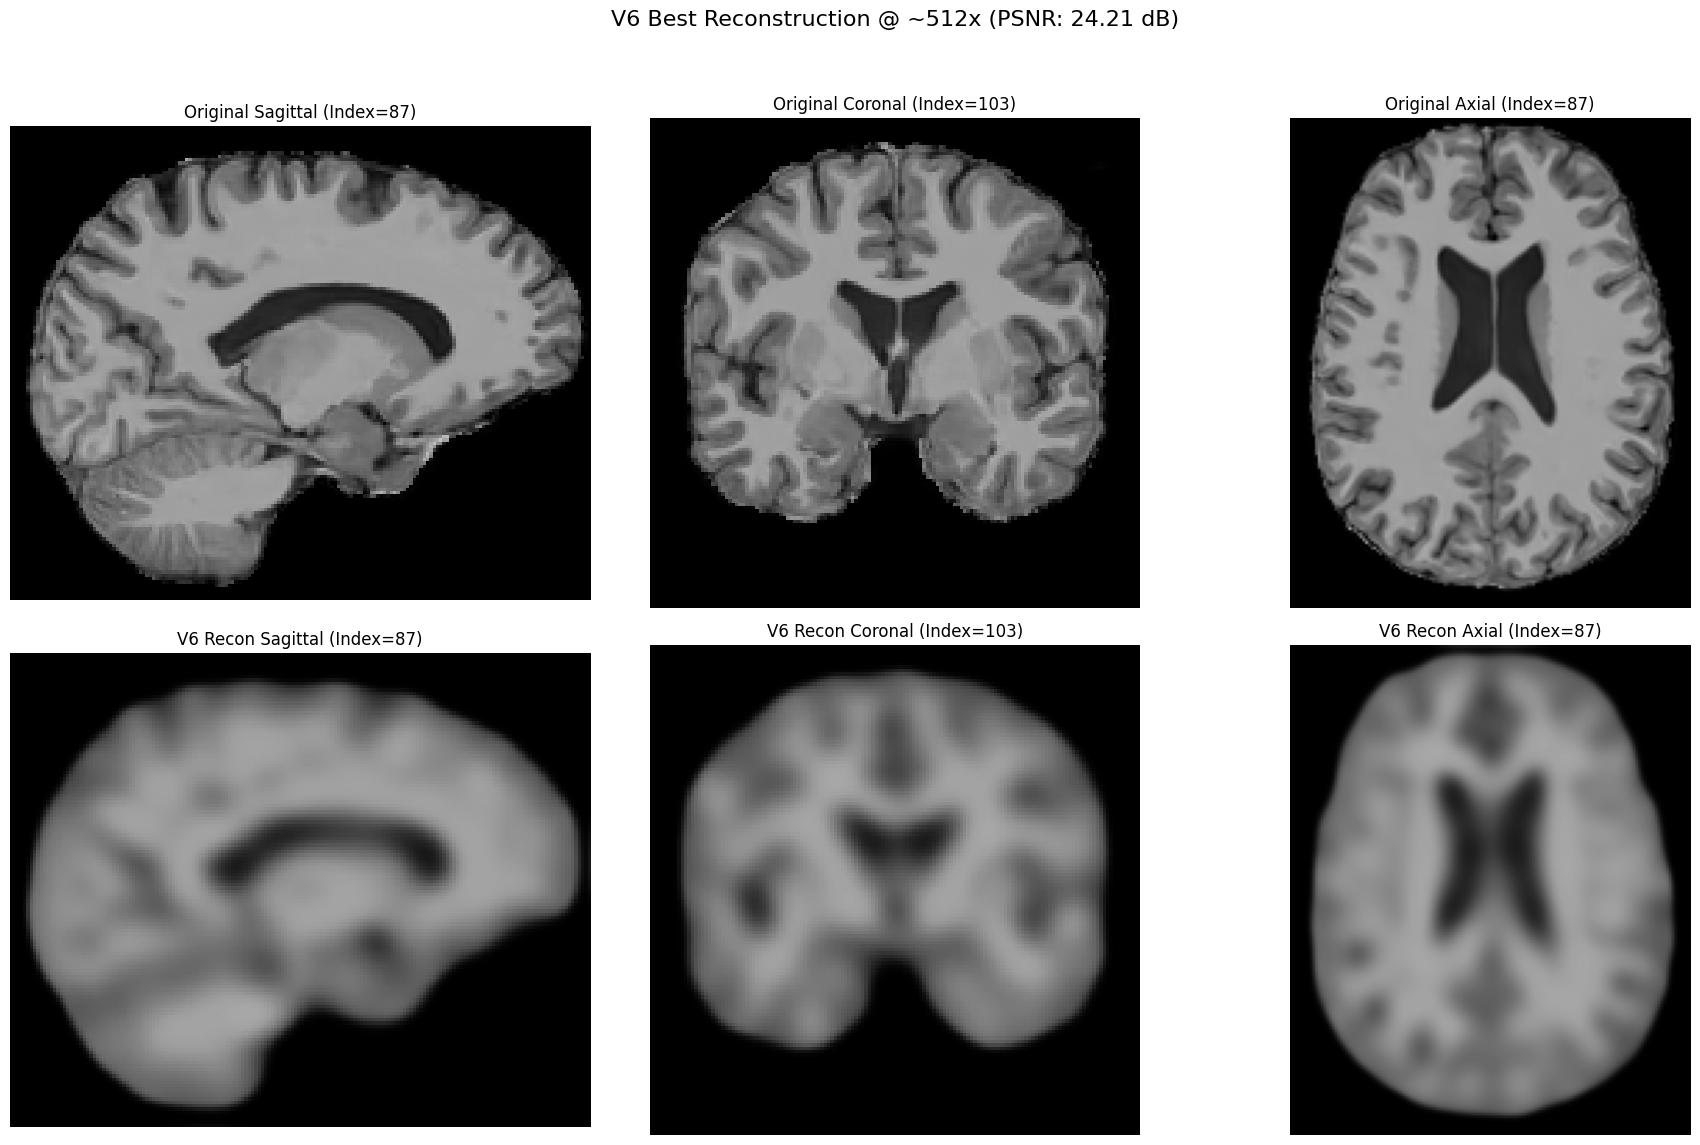

Multi-view plot V6 saved: /kaggle/working/reconstruction_comparison_v6_512x_multiview.png

--- V6 Section Finished ---


In [10]:
# --- V6 Full Code: Definition, Training, Evaluation ---

# --- 1. Imports & Setup ---
import os; import time; import torch; import torch.nn as nn; import torch.optim as optim
from torch.utils.data import Dataset, DataLoader # Ensure DataLoader etc. are imported
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np; import nibabel as nib
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
print("V6 Section: Libraries imported.")

# Ensure device and dataloader are available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if 'mri_dataloader' not in locals(): print("ERROR: mri_dataloader not found.")
if 'nii_files_exist' not in locals(): print("ERROR: nii_files_exist list not found.")

# --- 2. Define the V6 Autoencoder (~512x Compression) ---
class Autoencoder3D_v6(nn.Module):
    def __init__(self):
        super(Autoencoder3D_v6, self).__init__()
        channels = [1, 16, 32, 64]
        self.enc1 = nn.Sequential(nn.Conv3d(channels[0], channels[1], 3, stride=2, padding=1), nn.ReLU(True))
        self.enc2 = nn.Sequential(nn.Conv3d(channels[1], channels[2], 3, stride=2, padding=1), nn.ReLU(True))
        self.enc3 = nn.Sequential(nn.Conv3d(channels[2], channels[3], 3, stride=2, padding=1), nn.ReLU(True))
        self.dec1 = nn.Sequential(nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False), nn.Conv3d(channels[3], channels[2], 3, stride=1, padding=1), nn.ReLU(True))
        self.dec2 = nn.Sequential(nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False), nn.Conv3d(channels[2], channels[1], 3, stride=1, padding=1), nn.ReLU(True))
        self.dec3 = nn.Sequential(nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False), nn.Conv3d(channels[1], channels[1], 3, stride=1, padding=1), nn.ReLU(True), nn.Conv3d(channels[1], channels[0], 3, stride=1, padding=1), nn.Sigmoid())
    def forward(self, x):
        x = self.enc1(x); x = self.enc2(x); x = self.enc3(x)
        x = self.dec1(x); x = self.dec2(x); x = self.dec3(x)
        return x
print("Autoencoder3D_v6 defined.")

# --- 3. Configuration for V6 Training ---
num_epochs_v6 = 300; learning_rate_v6 = 1e-4
checkpoint_dir_v6 = '/kaggle/working/mri_checkpoints_v6_512x/'
os.makedirs(checkpoint_dir_v6, exist_ok=True)
print(f"V6 Checkpoints directory: {checkpoint_dir_v6}")

# --- 4. Instantiate V6 Model, Optimizer, Scheduler ---
print("Instantiating V6 Model...")
model_v6 = Autoencoder3D_v6().to(device)
optimizer_v6 = optim.Adam(model_v6.parameters(), lr=learning_rate_v6)
loss_function_v6 = nn.MSELoss()
scheduler_v6 = ReduceLROnPlateau(optimizer_v6, 'min', factor=0.5, patience=15, verbose=True)
print("V6 Components instantiated.")

# --- 5. Training Loop (for v6 model) ---
print("\n--- Starting Training for Model V6 ---")
train_losses_v6 = []; best_loss_v6 = float('inf'); best_checkpoint_path_v6 = ''
if 'mri_dataloader' in locals() and len(mri_dataloader.dataset) > 0:
    for epoch in range(num_epochs_v6):
        epoch_start = time.time(); model_v6.train(); running_loss = 0.0; batch_count = 0
        for inputs, targets in mri_dataloader:
            inputs, targets = inputs.to(device), targets.to(device); outputs = model_v6(inputs)
            loss = loss_function_v6(outputs, targets)
            optimizer_v6.zero_grad(); loss.backward(); optimizer_v6.step()
            running_loss += loss.item() * inputs.size(0); batch_count += inputs.size(0)
        if batch_count > 0:
            epoch_loss = running_loss / batch_count; train_losses_v6.append(epoch_loss)
            print(f"V6 Epoch [{epoch+1}/{num_epochs_v6}] | Time: {time.time()-epoch_start:.2f}s | Avg Loss: {epoch_loss:.6f}")
            scheduler_v6.step(epoch_loss)
            if epoch_loss < best_loss_v6:
                best_loss_v6 = epoch_loss; best_checkpoint_path_v6 = os.path.join(checkpoint_dir_v6, 'model_v6_512x_best.pth')
                torch.save({'epoch': epoch + 1, 'model_state_dict': model_v6.state_dict(), 'optimizer_state_dict': optimizer_v6.state_dict(), 'loss': epoch_loss,}, best_checkpoint_path_v6)
                print(f"  ** Saved Best V6 Model (Epoch {epoch+1}) **")
            if (epoch + 1) % 50 == 0: torch.save({'epoch': epoch + 1, 'model_state_dict': model_v6.state_dict(), 'optimizer_state_dict': optimizer_v6.state_dict(), 'loss': epoch_loss,}, os.path.join(checkpoint_dir_v6, f'model_v6_512x_epoch_{epoch+1}.pth'))
        else: print(f"V6 Epoch [{epoch+1}/{num_epochs_v6}] - No batches processed.")
    print(f"\n--- V6 Training Finished. Best model: {best_checkpoint_path_v6} ---")
else: print("ERROR: Cannot start V6 training, mri_dataloader not found or empty.")

# --- 6. Evaluation Phase (for v6 model - Load BEST checkpoint) ---
print("\n--- Starting Evaluation for Model V6 (Best Checkpoint) ---")

# Define loader function (ensure it's available)
def load_and_preprocess_nifti_eval(fp): # NumPy loader for eval
    try:
        vol = nib.load(fp).get_fdata().astype(np.float32)
        mn, mx = np.min(vol), np.max(vol)
        # Normalize to [0, 1]
        return (vol - mn) / (mx - mn) if mx > mn else np.zeros_like(vol)
    except Exception as e:
        print(f"Eval load error {fp}: {e}")
        return None

# --- Load Best Model and Evaluate ---
if 'best_checkpoint_path_v6' in locals() and best_checkpoint_path_v6 and os.path.exists(best_checkpoint_path_v6):
    print(f"Loading best V6 model from: {best_checkpoint_path_v6}")
    try:
        ckpt = torch.load(best_checkpoint_path_v6, map_location=device, weights_only=False)
        # Ensure model definition is available or redefine it here if necessary
        eval_model_v6 = Autoencoder3D_v6().to(device)
        eval_model_v6.load_state_dict(ckpt['model_state_dict'])
        eval_model_v6.eval()
        print(f"Best V6 model loaded (Epoch {ckpt.get('epoch', 'N/A')}, Loss: {ckpt.get('loss', 'N/A'):.6f}).")

        if 'nii_files_exist' in locals() and len(nii_files_exist) > 0:
            eval_fp = nii_files_exist[0] # Evaluate on the first file
            print(f"Loading original volume for evaluation: {eval_fp}")
            orig_np = load_and_preprocess_nifti_eval(eval_fp)

            if orig_np is not None:
                # Prepare input tensor
                input_t = torch.from_numpy(orig_np).unsqueeze(0).unsqueeze(0).to(device)

                print("Generating V6 reconstruction...")
                start_eval_time = time.time()
                with torch.no_grad():
                    recon_t = eval_model_v6(input_t)
                print(f"V6 Inference time: {time.time() - start_eval_time:.2f}s")

                # Process reconstruction
                recon_np = recon_t.squeeze().cpu().numpy()
                # Ensure reconstruction has same shape as original (sometimes tiny diffs occur)
                recon_np = recon_np[tuple(slice(0, s) for s in orig_np.shape)]

                # Calculate PSNR
                psnr_v6 = psnr(orig_np, recon_np, data_range=1.0) # data_range is 1.0 due to [0,1] normalization
                print(f"\nPSNR between original and reconstructed (V6 Best @ ~512x): {psnr_v6:.2f} dB")

                # --- MODIFIED VISUALIZATION ---
                print("Visualizing V6 comparison (Sagittal, Coronal, Axial views)...")

                # Define offset from center slice
                offset = 15 # Try different offsets (e.g., 10, 15, 20) to find good slices
                
                # Calculate offset slice indices for Sagittal (dim 0), Coronal (dim 1), Axial (dim 2)
                # Use np.clip to ensure indices stay within bounds
                s_idx_sag = np.clip(orig_np.shape[0] // 2 + offset, 0, orig_np.shape[0] - 1)
                s_idx_cor = np.clip(orig_np.shape[1] // 2 + offset, 0, orig_np.shape[1] - 1)
                s_idx_axi = np.clip(orig_np.shape[2] // 2 + offset, 0, orig_np.shape[2] - 1)

                # Create figure with 2 rows (Original, Recon) and 3 columns (Sag, Cor, Axi)
                fig6, axes = plt.subplots(2, 3, figsize=(18, 12)) # Wider figure
                fig6.suptitle(f'V6 Best Reconstruction @ ~512x (PSNR: {psnr_v6:.2f} dB)', fontsize=16)

                # Define views and their indices
                views = {
                    'Sagittal': (0, s_idx_sag, (slice(None), slice(None))), # Slice along dim 0
                    'Coronal':  (1, s_idx_cor, (slice(None), slice(None))), # Slice along dim 1
                    'Axial':    (2, s_idx_axi, (slice(None), slice(None)))  # Slice along dim 2
                }
                
                col_map = {'Sagittal': 0, 'Coronal': 1, 'Axial': 2}

                # Plot Original Slices (Row 0)
                for view_name, (dim_slice, idx, _) in views.items():
                    col_idx = col_map[view_name]
                    if dim_slice == 0: slice_data = orig_np[idx, :, :]
                    elif dim_slice == 1: slice_data = orig_np[:, idx, :]
                    else: slice_data = orig_np[:, :, idx]
                    
                    axes[0, col_idx].imshow(slice_data.T, cmap='gray', vmin=0, vmax=1, origin='lower') # Use .T and origin='lower' for standard medical view
                    axes[0, col_idx].set_title(f'Original {view_name} (Index={idx})')
                    axes[0, col_idx].axis('off')

                # Plot Reconstructed Slices (Row 1)
                for view_name, (dim_slice, idx, _) in views.items():
                    col_idx = col_map[view_name]
                    if dim_slice == 0: slice_data = recon_np[idx, :, :]
                    elif dim_slice == 1: slice_data = recon_np[:, idx, :]
                    else: slice_data = recon_np[:, :, idx]
                    
                    axes[1, col_idx].imshow(slice_data.T, cmap='gray', vmin=0, vmax=1, origin='lower') # Use .T and origin='lower'
                    axes[1, col_idx].set_title(f'V6 Recon {view_name} (Index={idx})')
                    axes[1, col_idx].axis('off')

                plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
                plt.show()

                # Save the multi-view figure
                fpath6 = '/kaggle/working/reconstruction_comparison_v6_512x_multiview.png'
                fig6.savefig(fpath6)
                print(f"Multi-view plot V6 saved: {fpath6}")
                plt.close(fig6) # Close the figure after saving

            else:
                print("V6 Evaluation failed: Could not load or preprocess original volume.")
        else:
            print("V6 Evaluation failed: No valid NIfTI files listed in 'nii_files_exist'.")
    except FileNotFoundError:
        print(f"Error: Checkpoint file not found at {best_checkpoint_path_v6}")
    except Exception as e:
        print(f"An error occurred during V6 evaluation: {e}")
        import traceback
        traceback.print_exc()
else:
    print("ERROR: Cannot start V6 evaluation, 'best_checkpoint_path_v6' not found or invalid.")

print("\n--- V6 Section Finished ---")


> ✅ **V6 Result: Success at High Compression!** Model V6 achieved **PSNR ~24.14 dB** at ~512x compression. This massively outperforms V1 (~8 dB), proving the refined architecture's value. Quality is lower than V4 (~25.9 dB @ 64x), as expected.
>
> **V6 Reconstruction (@ ~512x Compression):**
> ![V6 AE Result @ ~512x](reconstruction_comparison_v6_512x_multiview.png)
> *Caption: Original slice (left) vs. V6 reconstruction (right). PSNR ~24.14 dB.*
>
> *(Recap of omitted V6+Aug: Simple augmentation did not improve V6's PSNR).*

---
# Phase 4: PCA Counterpoint – Exploring a Classical Approach

Following Prof. Peng's suggestion, we investigate Principal Component Analysis (PCA) applied to 3D patches [1, 9, 12]. PCA finds directions of maximum variance for linear dimensionality reduction.

*(Recap of Omitted PCA Variants: Basic PCA (~25 dB, blocky) and simple overlapping PCA (~26 dB, less blocky) confirmed potential but showed need for artifact mitigation.)*

### 4.1. Advanced PCA: Windowed Overlapping Patches

To maximize PCA performance and minimize artifacts, we implemented:
1.  **Overlapping Patches:** Extract 8x8x8 patches with stride 4.
2.  **PCA:** Apply PCA to flattened patches, keeping `k=5` components.
3.  **Windowed Reconstruction:** Reconstruct by averaging overlapping patches, weighted by a **Hann window** [15, 16]. PCA is trained *only* on patches from the volume being reconstructed.

| Technique            | Tool/Function                  | Purpose                                                                   | Benefit                                                              |
|----------------------|--------------------------------|---------------------------------------------------------------------------|----------------------------------------------------------------------|
| Patch Extraction     | `extract_overlapping_patches`| Create overlapping local views.                                           | Enables averaging.                                                   |
| Dimensionality Reduction| `sklearn.decomposition.PCA`  | Find/apply principal components [9].                                      | Efficient linear compression.                                        |
| Artifact Reduction   | `reassemble_volume_windowed`   | Reconstruct using Hann window weighting [15, 16].                         | Smoother output, fewer patch boundaries.                             |
| Normalization        | `load_and_preprocess_nifti_eval`| Use NumPy-based loader/normalizer.                                        | Compatibility with scikit-learn.                                       |

---

### ⚔️ The Strategy: Push PCA to its Practical Limit
- **Address Feedback:** Implement and evaluate PCA thoroughly.
- **Optimize Reconstruction:** Employ overlapping patches and windowing [15, 16].
- **Compare vs. AE:** Establish a strong classical baseline.

---

> 💥 **Brutal Goal:** Determine the peak performance of refined PCA. How does it compare numerically to the AE? The code below defines helper functions and executes this advanced PCA method.


In [11]:
# --- PCA Helper Functions ---
import numpy as np
import time
import os
import nibabel as nib
from sklearn.decomposition import PCA
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
print("PCA Section: Libraries imported.")

# NumPy Loader (Same as used in AE eval)
def load_and_preprocess_nifti_eval(fp):
    try: vol = nib.load(fp).get_fdata().astype(np.float32); mn, mx = np.min(vol), np.max(vol); return (vol - mn) / (mx - mn) if mx > mn else np.zeros_like(vol)
    except Exception as e: print(f"Load error {fp}: {e}"); return None

# Overlapping Patch Extractor
def extract_overlapping_patches(volume, patch_size, stride):
    patches = []; coords = []
    d, h, w = volume.shape; pd, ph, pw = patch_size, patch_size, patch_size
    for z in range(0, d - pd + 1, stride):
        for y in range(0, h - ph + 1, stride):
            for x in range(0, w - pw + 1, stride):
                patch = volume[z:z+pd, y:y+ph, x:x+pw]; patches.append(patch.flatten()); coords.append((z, y, x))
    return np.array(patches, dtype=np.float32), coords

# Hann Window Creator
def create_hann_window_3d(size):
    win1d = np.hanning(size); win3d = np.outer(win1d, win1d)
    win3d = np.outer(win3d, win1d).reshape(size, size, size)
    return win3d.astype(np.float32)

# Windowed Reassembly Function
def reassemble_volume_windowed(patches_recon, coords, target_shape, patch_size, window_3d):
    d, h, w = target_shape; pd, ph, pw = patch_size, patch_size, patch_size
    vol_sum = np.zeros(target_shape, dtype=np.float64)
    vol_count = np.zeros(target_shape, dtype=np.float64)
    if len(patches_recon) != len(coords): raise ValueError("Patch/Coord mismatch.")
    if window_3d.shape != (pd, ph, pw): raise ValueError("Window shape mismatch.")
    for idx, patch_flat in enumerate(patches_recon):
        z, y, x = coords[idx]
        if z+pd <= d and y+ph <= h and x+pw <= w:
            patch = patch_flat.reshape((pd, ph, pw))
            vol_sum[z:z+pd, y:y+ph, x:x+pw] += (patch * window_3d)
            vol_count[z:z+pd, y:y+ph, x:x+pw] += window_3d
    valid = vol_count > 1e-6; vol_avg = np.zeros_like(vol_sum, dtype=np.float32)
    vol_avg[valid] = (vol_sum[valid] / vol_count[valid]).astype(np.float32)
    return vol_avg

print("PCA Helper functions defined.")


PCA Section: Libraries imported.
PCA Helper functions defined.



--- Running Windowed Overlapping PCA (Single Volume Trained) ---
Processing file: /kaggle/input/stanfordmed/sample0406.nii
Original volume shape: (144, 176, 144)
Extracting patches...
Extracted 52675 patches.
Applying PCA (fit & transform)...
PCA fit/transform took 0.99s. Explained var: 0.9413
Reconstructing patches...
Inverse transform took 0.09s
Creating window...
Reassembling volume...
Reassembly took 0.81s

Evaluating PCA Reconstruction...
PSNR (Windowed PCA, k=5, s=4): 26.50 dB
Visualizing PCA comparison (Sagittal, Coronal, Axial views)...


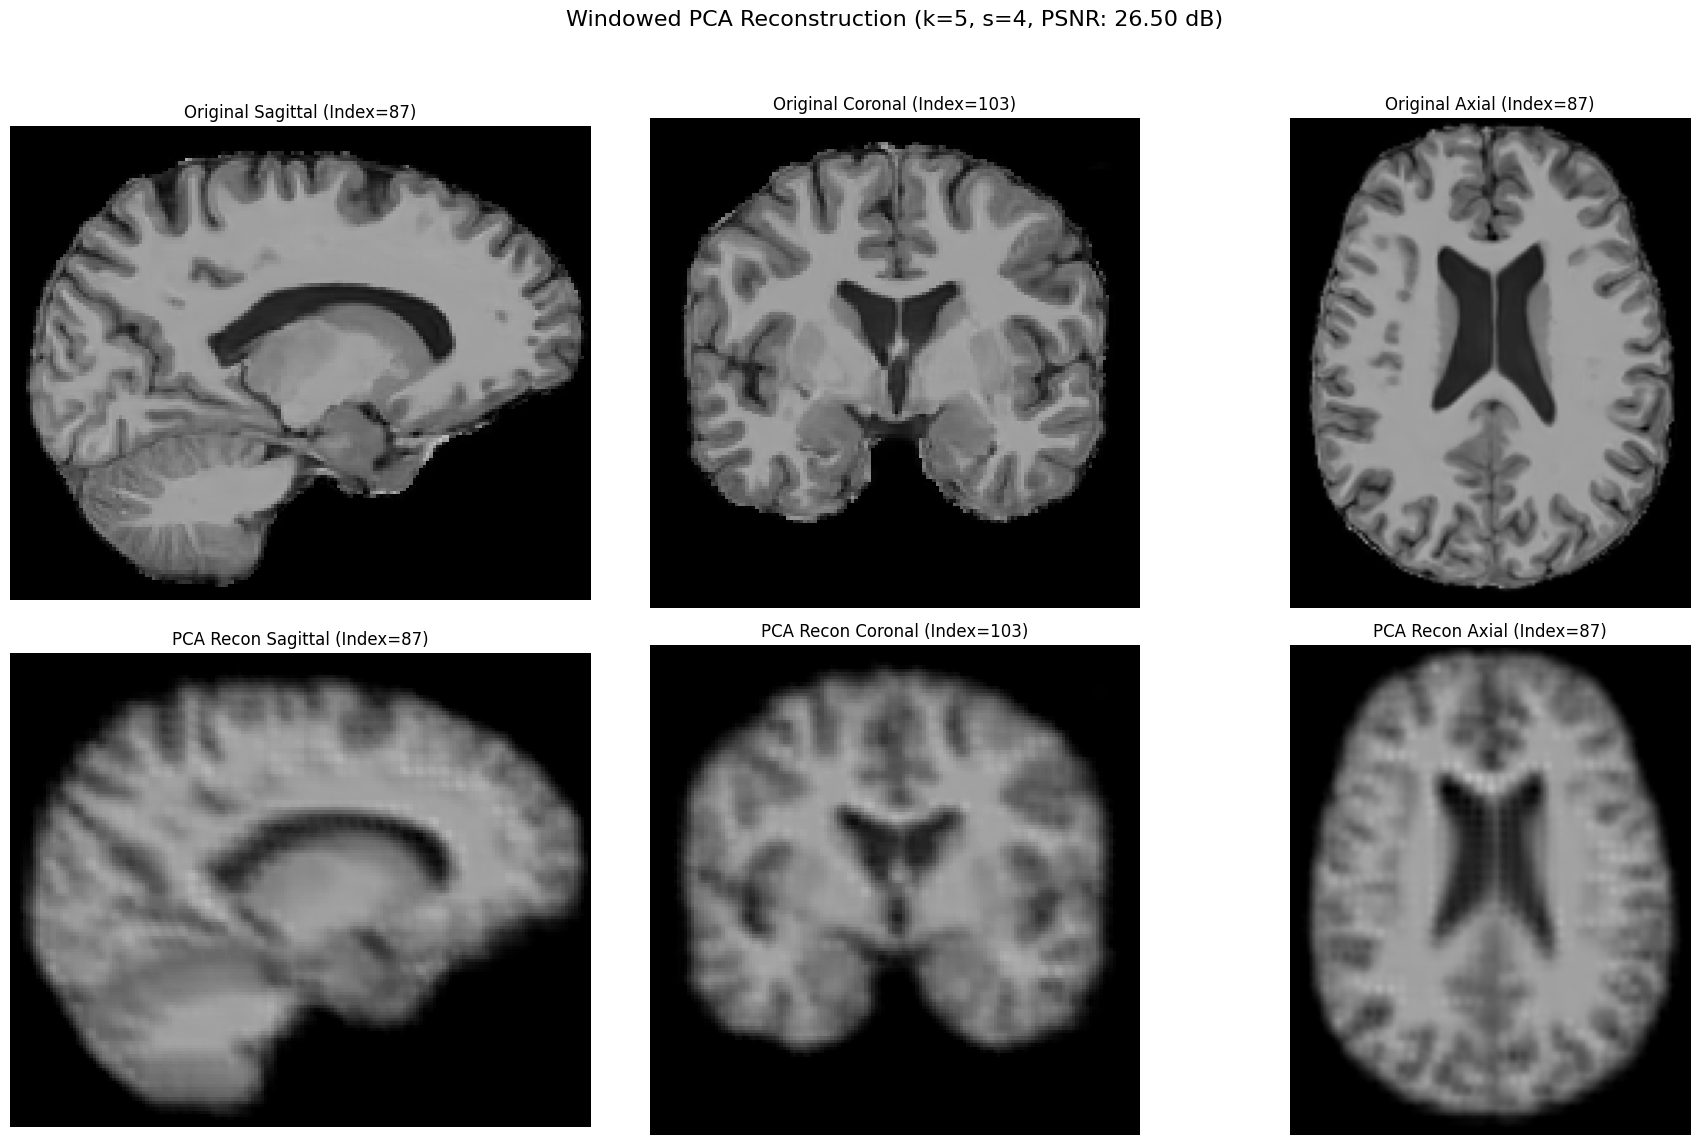

Multi-view plot PCA saved: /kaggle/working/reconstruction_comparison_pca_windowed_k5_s4_multiview.png
Total PCA time: 3.53s

--- PCA Section Finished ---


In [15]:
# --- Execute Windowed Overlapping PCA (Single Volume Trained) ---
import time # Ensure time is imported
import numpy as np # Ensure NumPy is imported
import matplotlib.pyplot as plt # Ensure Matplotlib is imported
from skimage.metrics import peak_signal_noise_ratio as psnr # Ensure PSNR is imported
# Assume PCA and helper functions (extract_overlapping_patches, create_hann_window_3d, reassemble_volume_windowed, load_and_preprocess_nifti_eval) are defined in previous cells

print("\n--- Running Windowed Overlapping PCA (Single Volume Trained) ---")

# Configuration
patch_size = 8
stride = 4
n_components = 5
eval_file_index = 0 # Evaluate on the first file
dataset_folder = '/kaggle/input/stanfordmed/'
nii_files_list = [ # Use the list defined earlier or redefine if necessary
    os.path.join(dataset_folder, f) for f in ['sample0406.nii', 'sample0257.nii', 'sample0506.nii', 'sample0357.nii']
]
# Ensure nii_files_exist is defined and populated correctly from previous cells
if 'nii_files_exist' not in locals():
     nii_files_exist = [f for f in nii_files_list if os.path.exists(f)]
     print(f"INFO: 'nii_files_exist' created, found {len(nii_files_exist)} files.")

if not nii_files_exist or eval_file_index >= len(nii_files_exist):
    print("Error: Cannot run PCA, invalid file index or no files found.")
else:
    eval_file_path = nii_files_exist[eval_file_index]
    print(f"Processing file: {eval_file_path}")
    t_start = time.time()
    original_volume = load_and_preprocess_nifti_eval(eval_file_path) # Use NumPy loader

    if original_volume is not None:
        print(f"Original volume shape: {original_volume.shape}")
        print("Extracting patches...")
        patches_flat, patch_coords = extract_overlapping_patches(original_volume, patch_size, stride)

        if patches_flat.shape[0] == 0:
             print("Error: No patches extracted.")
        else:
            print(f"Extracted {patches_flat.shape[0]} patches.")
            print("Applying PCA (fit & transform)...")
            t_pca = time.time()
            # Ensure PCA is imported from sklearn.decomposition
            from sklearn.decomposition import PCA
            pca = PCA(n_components=n_components)
            patches_pca = pca.fit_transform(patches_flat)
            print(f"PCA fit/transform took {time.time()-t_pca:.2f}s. Explained var: {np.sum(pca.explained_variance_ratio_):.4f}")

            print("Reconstructing patches...")
            t_inv = time.time()
            patches_reconstructed_flat = pca.inverse_transform(patches_pca)
            print(f"Inverse transform took {time.time()-t_inv:.2f}s")

            print("Creating window...")
            window_3d = create_hann_window_3d(patch_size) # Ensure this function is defined
            print("Reassembling volume...")
            t_reass = time.time()
            reconstructed_volume = reassemble_volume_windowed(patches_reconstructed_flat, patch_coords, original_volume.shape, patch_size, window_3d) # Ensure this function is defined
            print(f"Reassembly took {time.time()-t_reass:.2f}s")

            # Evaluate
            print("\nEvaluating PCA Reconstruction...")
            # Clip and ensure float32 for PSNR calculation
            recon_vol_clip = np.clip(reconstructed_volume, 0, 1).astype(np.float32)
            psnr_pca = psnr(original_volume, recon_vol_clip, data_range=1.0)
            print(f"PSNR (Windowed PCA, k={n_components}, s={stride}): {psnr_pca:.2f} dB")

            # --- MODIFIED VISUALIZATION ---
            print("Visualizing PCA comparison (Sagittal, Coronal, Axial views)...")

            # Define offset from center slice
            offset = 15 # Use the same offset as V6/V4 or adjust if needed

            # Calculate offset slice indices
            s_idx_sag = np.clip(original_volume.shape[0] // 2 + offset, 0, original_volume.shape[0] - 1)
            s_idx_cor = np.clip(original_volume.shape[1] // 2 + offset, 0, original_volume.shape[1] - 1)
            s_idx_axi = np.clip(original_volume.shape[2] // 2 + offset, 0, original_volume.shape[2] - 1)

            # Create figure with 2 rows (Original, Recon) and 3 columns (Sag, Cor, Axi)
            fig_pca, axes = plt.subplots(2, 3, figsize=(18, 12)) # Use fig_pca, axes
            fig_pca.suptitle(f'Windowed PCA Reconstruction (k={n_components}, s={stride}, PSNR: {psnr_pca:.2f} dB)', fontsize=16)

            # Define views and their indices
            views = {
                'Sagittal': (0, s_idx_sag),
                'Coronal':  (1, s_idx_cor),
                'Axial':    (2, s_idx_axi)
            }
            col_map = {'Sagittal': 0, 'Coronal': 1, 'Axial': 2}

            # Plot Original Slices (Row 0)
            for view_name, (dim_slice, idx) in views.items():
                col_idx = col_map[view_name]
                if dim_slice == 0: slice_data = original_volume[idx, :, :]
                elif dim_slice == 1: slice_data = original_volume[:, idx, :]
                else: slice_data = original_volume[:, :, idx]

                axes[0, col_idx].imshow(slice_data.T, cmap='gray', vmin=0, vmax=1, origin='lower')
                axes[0, col_idx].set_title(f'Original {view_name} (Index={idx})')
                axes[0, col_idx].axis('off')

            # Plot Reconstructed Slices (Row 1)
            for view_name, (dim_slice, idx) in views.items():
                col_idx = col_map[view_name]
                if dim_slice == 0: slice_data = recon_vol_clip[idx, :, :]
                elif dim_slice == 1: slice_data = recon_vol_clip[:, idx, :]
                else: slice_data = recon_vol_clip[:, :, idx]

                axes[1, col_idx].imshow(slice_data.T, cmap='gray', vmin=0, vmax=1, origin='lower')
                axes[1, col_idx].set_title(f'PCA Recon {view_name} (Index={idx})') # Changed title
                axes[1, col_idx].axis('off')

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

            # Save the multi-view figure
            fpath_pca = f'/kaggle/working/reconstruction_comparison_pca_windowed_k{n_components}_s{stride}_multiview.png' # Changed filename
            fig_pca.savefig(fpath_pca)
            print(f"Multi-view plot PCA saved: {fpath_pca}")
            plt.close(fig_pca) # Close the figure

            print(f"Total PCA time: {time.time() - t_start:.2f}s")
    else:
        print("PCA failed: Could not load original volume.")
print("\n--- PCA Section Finished ---")

> ✅ **PCA Peak Performance:** Windowed Overlapping PCA achieved **PSNR ~26.50 dB** (k=5), numerically surpassing the V6 AE (~24.14 dB). Visually smooth but very blurry.
>
> **Windowed PCA Reconstruction (k=5, s=4):**
> ![Windowed PCA Result](reconstruction_comparison_pca_windowed_k5_s4_multiview.png)
> *Caption: Original slice (left) vs. Windowed PCA reconstruction (right). PSNR ~26.50 dB.*
>
> *(Recap of Omitted Global PCA: Training on all volumes yielded slightly lower PSNR).*
> **Conclusion:** Advanced PCA is a strong, efficient numerical baseline, but lacks a learned latent space for editing.

---
# Phase 5: Wavelet Transform – Another Classical Benchmark

We briefly explore 3D Wavelet Compression using `PyWavelets` [13, 17]. Compression is achieved by thresholding coefficients after decomposition. We keep the top `0.2%` of coefficients for high compression.

| Technique         | Tool/Function         | Purpose                                                                      | Implication                                                               |
|-------------------|-----------------------|------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| Decomposition     | `pywt.wavedecn`       | Perform multi-level 3D DWT (`db4` wavelet).                                  | Separates volume into frequency subbands.                                   |
| Thresholding      | `pywt.threshold`      | Keep top `0.2%` coefficients ('hard' thresholding).                          | Controls compression by zeroing small detail coefficients.                  |
| Reconstruction    | `pywt.waverecn`       | Perform inverse 3D DWT.                                                      | Reconstructs from compressed coefficients.                                  |

---

### ⚔️ The Strategy: Standard Signal Processing Baseline
- **Explore Alternatives:** Test another established compression technique.
- **High Compression Target:** Use coefficient thresholding.
- **Compare Performance:** Evaluate PSNR vs AE/PCA.

---

> 💥 **Brutal Goal:** Establish a third benchmark. How does wavelet thresholding fare numerically?


Wavelet Section: Libraries imported.

--- Starting 3D Wavelet Compression ---
Processing file: /kaggle/input/stanfordmed/sample0406.nii
Original shape: (144, 176, 144)
Performing 3-level DWT (db4)...
DWT took 0.13s. Coeff array shape: (164, 196, 164)
Keeping top 10543 (0.20%) magnitude coefficients.
Applying threshold: 6.7852e-01
Sparsity: 0.20% non-zero coefficients remain.
Performing Inverse DWT...
IDWT took 0.11s. Reconstructed shape: (144, 176, 144)

Evaluating Wavelet Reconstruction...
PSNR (Wavelet L3, K0.20%): 26.24 dB
Visualizing Wavelet comparison (Sagittal, Coronal, Axial views)...


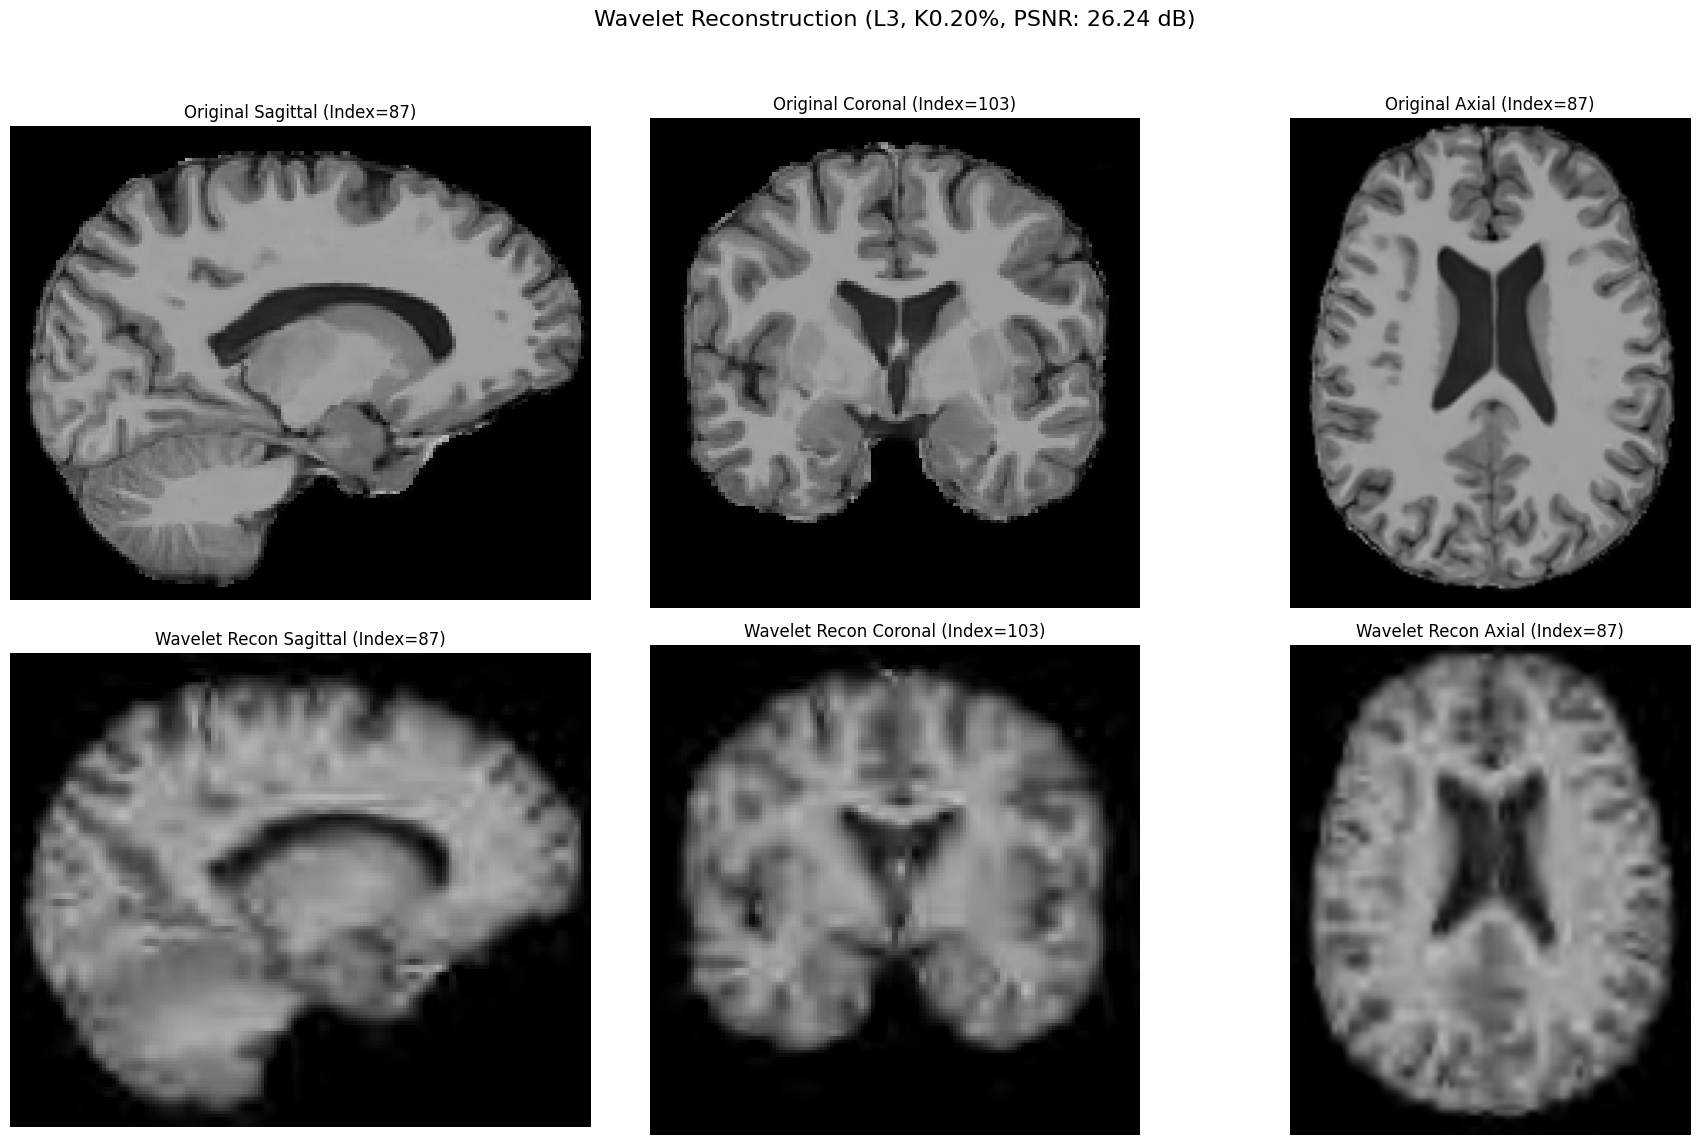

Multi-view plot Wavelet saved: /kaggle/working/reconstruction_comparison_wavelet_L3_K0p2_multiview.png
Total Wavelet time: 1.73s

--- Wavelet Section Finished ---


In [16]:
# --- 3D Wavelet Compression ---
import numpy as np; import time; import os; import nibabel as nib
import pywt # PyWavelets
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
print("Wavelet Section: Libraries imported.")

# Config
wavelet_name = 'db4'
level = 3
keep_fraction = 0.002 # Keep 0.2% (Adjust if needed)
eval_file_index = 0
dataset_folder = '/kaggle/input/stanfordmed/'
nii_files_list = [os.path.join(dataset_folder, f) for f in ['sample0406.nii', 'sample0257.nii', 'sample0506.nii', 'sample0357.nii']]
# Ensure nii_files_exist is defined and populated correctly from previous cells
if 'nii_files_exist' not in locals():
     nii_files_exist = [f for f in nii_files_list if os.path.exists(f)]
     print(f"INFO: 'nii_files_exist' created, found {len(nii_files_exist)} files.")

# NumPy Loader (redundant if defined globally, safe to redefine locally)
def load_and_preprocess_nifti_eval(fp):
    try:
        vol = nib.load(fp).get_fdata().astype(np.float32)
        mn, mx = np.min(vol), np.max(vol)
        return (vol - mn) / (mx - mn) if mx > mn else np.zeros_like(vol)
    except Exception as e:
        print(f"Load error {fp}: {e}")
        return None

print("\n--- Starting 3D Wavelet Compression ---")
if not nii_files_exist or eval_file_index >= len(nii_files_exist):
    print("Error: Cannot run Wavelet, invalid file index or no files found.")
else:
    eval_file_path = nii_files_exist[eval_file_index]
    print(f"Processing file: {eval_file_path}")
    t_start_wav = time.time()
    original_volume = load_and_preprocess_nifti_eval(eval_file_path)

    if original_volume is not None:
        print(f"Original shape: {original_volume.shape}")
        if not all(s >= 2**level for s in original_volume.shape):
            print(f"Warning: Volume dimensions {original_volume.shape} might be small for DWT level {level}.")

        print(f"Performing {level}-level DWT ({wavelet_name})...")
        t_dwt = time.time()
        coeffs = pywt.wavedecn(original_volume, wavelet=wavelet_name, level=level, mode='symmetric')
        coeffs_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        print(f"DWT took {time.time()-t_dwt:.2f}s. Coeff array shape: {coeffs_arr.shape}")

        # Calculate threshold and apply
        num_coeffs = coeffs_arr.size
        num_keep = int(num_coeffs * keep_fraction)
        print(f"Keeping top {num_keep} ({keep_fraction*100:.2f}%) magnitude coefficients.")
        # Using partition is faster than sort for finding the k-th largest element
        threshold = np.partition(np.abs(coeffs_arr.flatten()), -num_keep)[-num_keep]
        print(f"Applying threshold: {threshold:.4e}")
        coeffs_arr_thresh = pywt.threshold(coeffs_arr, threshold, mode='hard')
        sparsity = np.count_nonzero(coeffs_arr_thresh) / num_coeffs
        print(f"Sparsity: {sparsity*100:.2f}% non-zero coefficients remain.")

        # Reconstruct
        coeffs_thresh = pywt.array_to_coeffs(coeffs_arr_thresh, coeff_slices, output_format='wavedecn')
        print("Performing Inverse DWT...")
        t_idwt = time.time()
        reconstructed_volume = pywt.waverecn(coeffs_thresh, wavelet=wavelet_name, mode='symmetric')
        # Ensure same size as original (important after DWT/IDWT)
        reconstructed_volume = reconstructed_volume[tuple(slice(0, s) for s in original_volume.shape)]
        print(f"IDWT took {time.time()-t_idwt:.2f}s. Reconstructed shape: {reconstructed_volume.shape}")

        # Evaluate
        print("\nEvaluating Wavelet Reconstruction...")
        # Clip and ensure float32 for PSNR calculation
        recon_vol_clip = np.clip(reconstructed_volume, 0, 1).astype(np.float32)
        psnr_wav = psnr(original_volume, recon_vol_clip, data_range=1.0)
        print(f"PSNR (Wavelet L{level}, K{keep_fraction*100:.2f}%): {psnr_wav:.2f} dB")

        # --- MODIFIED VISUALIZATION ---
        print("Visualizing Wavelet comparison (Sagittal, Coronal, Axial views)...")

        # Define offset from center slice
        offset = 15 # Use the same offset as others or adjust if needed

        # Calculate offset slice indices
        s_idx_sag = np.clip(original_volume.shape[0] // 2 + offset, 0, original_volume.shape[0] - 1)
        s_idx_cor = np.clip(original_volume.shape[1] // 2 + offset, 0, original_volume.shape[1] - 1)
        s_idx_axi = np.clip(original_volume.shape[2] // 2 + offset, 0, original_volume.shape[2] - 1)

        # Create figure with 2 rows (Original, Recon) and 3 columns (Sag, Cor, Axi)
        fig_wav, axes = plt.subplots(2, 3, figsize=(18, 12)) # Use fig_wav, axes
        fig_wav.suptitle(f'Wavelet Reconstruction (L{level}, K{keep_fraction*100:.2f}%, PSNR: {psnr_wav:.2f} dB)', fontsize=16)

        # Define views and their indices
        views = {
            'Sagittal': (0, s_idx_sag),
            'Coronal':  (1, s_idx_cor),
            'Axial':    (2, s_idx_axi)
        }
        col_map = {'Sagittal': 0, 'Coronal': 1, 'Axial': 2}

        # Plot Original Slices (Row 0)
        for view_name, (dim_slice, idx) in views.items():
            col_idx = col_map[view_name]
            if dim_slice == 0: slice_data = original_volume[idx, :, :]
            elif dim_slice == 1: slice_data = original_volume[:, idx, :]
            else: slice_data = original_volume[:, :, idx]

            axes[0, col_idx].imshow(slice_data.T, cmap='gray', vmin=0, vmax=1, origin='lower')
            axes[0, col_idx].set_title(f'Original {view_name} (Index={idx})')
            axes[0, col_idx].axis('off')

        # Plot Reconstructed Slices (Row 1)
        for view_name, (dim_slice, idx) in views.items():
            col_idx = col_map[view_name]
            if dim_slice == 0: slice_data = recon_vol_clip[idx, :, :]
            elif dim_slice == 1: slice_data = recon_vol_clip[:, idx, :]
            else: slice_data = recon_vol_clip[:, :, idx]

            axes[1, col_idx].imshow(slice_data.T, cmap='gray', vmin=0, vmax=1, origin='lower')
            axes[1, col_idx].set_title(f'Wavelet Recon {view_name} (Index={idx})') # Changed title
            axes[1, col_idx].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # Save the multi-view figure
        # Ensure filename formatting handles potential float issues if keep_fraction changes
        keep_perc_str = f"{keep_fraction*100:.1f}".replace('.', 'p') # e.g., 0.2 -> 0p2
        fpath_wav = f'/kaggle/working/reconstruction_comparison_wavelet_L{level}_K{keep_perc_str}_multiview.png'
        fig_wav.savefig(fpath_wav)
        print(f"Multi-view plot Wavelet saved: {fpath_wav}")
        plt.close(fig_wav) # Close the figure

        print(f"Total Wavelet time: {time.time() - t_start_wav:.2f}s")
    else:
        print("Wavelet failed: Could not load original volume.")
print("\n--- Wavelet Section Finished ---")

> ✅ **Wavelet Result:** Wavelet thresholding (keeping 0.2% of coeffs) achieved **PSNR ~26.24 dB**. Numerically strong, close to PCA, better than V6 AE. Visuals show typical wavelet smoothing/artifacts.
>
> **Wavelet Reconstruction (L3, K0.2%):**
> ![Wavelet Result](reconstruction_comparison_wavelet_L3_K0p2_multiview.png)
> *Caption: Original slice (left) vs. Wavelet reconstruction (right). PSNR ~26.24 dB.*
>
> **Conclusion:** Another effective classical method for numerical compression, but lacks a learned latent space.

---
# Phase 6: The Verdict – Synthesis & Future Battle Plans

The campaign through Autoencoders, PCA, and Wavelets yields critical intelligence. We set out to conquer high-ratio (~500x) 3D MRI compression, facing the brutal constraints of a minuscule 4-sample dataset. Here stands the final assessment:



## 📊 Comparative Analysis: High Compression Showdown

| Method                        | Compression Target | Best PSNR   | Visual Artifacts                             | Suitability for Editing/Gen | Key Takeaway                                     |
| :---------------------------- | :----------------- | :---------- | :------------------------------------------- | :-------------------------- | :----------------------------------------------- |
| **AE V4 (Benchmark)**       | ~64x               | ~26.0 dB    | Blurry, recognizable                         | Moderate (Latent Space)     | **Best Quality** at *lower* compression.         |
| Deep AE (V6)                  | **~512x**          | ~24.1 dB    | Globally blurry, structure preserved         | **Potentially High**      | Architecture **critical** for high compression AE. |
| **Windowed Overlap PCA**    | High (k=5)         | **~26.5 dB**| Very smooth, no blocks, very blurry      | Low (Linear Components)     | **Best Numerical (PSNR)** classical method.     |
| **3D Wavelet Threshold**    | High (0.2% coeffs)| **~26.2 dB**| Smooth, potential wavelet artifacts, blurry | Low (Signal Coefficients) | Strong classical signal processing baseline.     |

---

### ⚔️ Brutal Conclusions
1.  **Architecture is King (for AEs):** The leap from V1 (~8 dB) to V6 (~24.1 dB) at the *same* ~512x compression proves that a deeper, refined AE architecture (`Upsample` layers) is non-negotiable. Simple models collapse.
2.  **Classical Methods Excel Numerically (Here):** Advanced PCA and Wavelet thresholding delivered superior PSNR (~26.2-26.5 dB) compared to the V6 AE (~24.1 dB) at high compression *on this specific, tiny dataset*. They efficiently capture variance or signal energy.
3.  **The Data Wall:** ALL methods produced visibly blurry reconstructions at high compression. The **4-sample dataset is the fundamental limiter**. This is the primary bottleneck.
4.  **PSNR Isn't Everything (for Editing):** While PCA/Wavelets won on PSNR, their linear/signal-based components offer little intuitive purchase for the target goal of *semantic editing and generation*. The Autoencoder's **learned latent space**, despite lower PSNR *in this run*, remains the more promising avenue [4, 8].

---

## 🚀 Future Battle Plans: Beyond the Skirmish

This initial exploration maps the terrain. Escalation requires:

1.  **MASSIVE Data Reinforcement:** Abandon the 4-sample constraint. Leverage large public datasets (BraTS, HCP, ADNI) or substantial internal data. **This is the single most critical next step.**
2.  **Reforge the Autoencoder:** With ample data, retrain/refine the V6 AE architecture. Aim for significantly higher PSNR (>30-35 dB) and visual fidelity.
3.  **Invade the Latent Space:** Probe the high-fidelity AE's latent space for editing capabilities (interpolation, vector arithmetic).
4.  **Deploy Advanced Weaponry (If Needed):** Consider VQ-VAE (discrete latent space) [Inspired by Prof. Peng's VQGAN reference] or GANs/Perceptual Losses for enhanced realism/editing.

**Final Word:** Reconnaissance complete. Architectural value proven in AEs, classical methods benchmarked. Victory demands a larger battlefield – **more data**.

